TO DO : 
Realizacja ćwiczenia
- Zapoznanie się z metodą reprezentacji wiedzy, jaką są drzewa decyzyjne
- Zapoznanie się z klasyczną implementacją indukcji drzew decyzyjnych – C4.5
- Zapoznanie się z platformą R
- Przebadanie działania metody C4.5 na wybranych zbiorach
- Przebadanie wpływu parametrów na skuteczność/efektywność metody (rozmiar drzewa a miary
jakości klasyfikatora FSC,Rec,Prec, też Acc)
- Sporządzenie sprawozdania z ćwiczenia – 5-10 stron – tylko najważniejsze elementy.


3. Wczytanie danych → 3 zbiory + iris (testy, czy działa?)



In [54]:
options(warn=-1) #Wyłączenie warningów aby w sprawozdaniu niebyły drukowane
library(tidyverse)
library(C50) #Drzewa decyzyjne C5.0
library(caret)#Pakiet do uczenia maszynowego
library(MLmetrics)# Pakiet zawierający metryki takie jak Fscore, Precision itp.


In [55]:
print("Iris data")
iris_data = read.csv(file = "iris.csv") #załaduj do iris_data dane Iris.

[1] "Iris data"


In [56]:
wine_data = read.csv(file = "wine.csv")

In [57]:
glass_data = read.csv(file = "glass.csv")

In [67]:
seed_data = read.csv(file = "seeds.csv")

In [58]:
#install.packages("MLmetrics")

Funkcja zwracająca wyćwiczony model drzewa. 

In [59]:
TreeModel_Test <- function(data_set, start_col_number, last_col_number )
{# nie można plotować! https://stackoverflow.com/questions/31738045/in-r-error-in-is-data-framedata-object-not-found-c5-0-plot
in_train <- sample(1:nrow(iris_data), size = 100)
train_data <- data_set[ in_train,]
test_data  <- data_set[-in_train,]
tree_mod <- C5.0(x = train_data[, start_col_number:(last_col_number-1)], y = train_data[,last_col_number])
    print(tree_mod)
#pr <- predict(tree_mod,test_data[start_col_number:(last_col_number-1)])
res <- predict(tree_mod,test_data[start_col_number:(last_col_number-1)])
  
    print(test_data)
    print(list(res))
print(fScore(test_data,list(res)))
}

In [60]:
metrics <- function(data, lev = NULL, model = NULL) {
  f1_val <- F1_Score(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  
    
  rec_val <-Recall(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  sen_val = Sensitivity(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  pre_val = Precision(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  acc_val = Accuracy(y_pred = data$pred, y_true = data$obs)
 #   if(is.na(f1_val) | is.na(rec_val) | is.na(sen_val) | is.na(pre_val) | is.na(acc_val)){
 #       print(data)
 #       print(f1_val) # precision + recal in denominator care if not 0 then NaN
 #       print(rec_val)
 #       print(sen_val)
 #       print(pre_val)
 #       print(acc_val)
   #}  
  
  c(fScore = f1_val,Recall = rec_val, Sensitivity = sen_val, Precision = pre_val,Accuracy=acc_val)
}

In [61]:
TreeModel_caret <- function(param_names,dataset,model_type,starting_col_number,last_col_number,formula,folds,winnowing,fuzzy,GlobalPruning
){
    test = dataset$last_col_number
    dataset[,ncol(dataset)] = as.factor(dataset[,ncol(dataset)])
    y = dataset[,(last_col_number-1)] #class column
    index = createDataPartition(y=y, p=0.7, list=FALSE)
    train.set = dataset[index,starting_col_number:last_col_number]
    test.set = dataset[-index,starting_col_number:last_col_number]
    train.control <- trainControl(#https://www.rdocumentation.org/packages/C50/versions/0.1.3/topics/C5.0Control
        method = "cv",
        number = folds,
        savePredictions = "all",
        summaryFunction = metrics
    )
    
    Control <- C5.0Control(
        winnow = winnowing,
        fuzzyThreshold = fuzzy,
        noGlobalPruning = GlobalPruning
    )
    tree <- train(formula,
                  data=train.set, 
                  method="C5.0",
                  control = Control,
                  tuneGrid = data.frame(trials = 1, model = c(model_type), winnow = winnowing),
                  trControl = train.control)
   # print(tree$resample)
    f1 = tree$results$fScore
    rec = tree$results$Recall
    sen = tree$results$Sensitivity
    acc = tree$results$Accuracy
    prec= tree$results$Precision
    size = tree$finalModel$size
    research_frame<-data.frame(param_names,f1,acc,rec,prec,size)
    names(research_frame)<-c("params","f1","acc","rec","prec","Tree_size")
    return(research_frame)
}

Plot_Tree <- function(treeModel){
  plot(treeModel, uniform=TRUE,
     main="Classification Tree")
text(treeModel, all=TRUE, cex=.8)  
}

In [62]:
model <- TreeModel_caret('fuck',iris_data,"rules",1,6,Species~. ,10,FALSE,TRUE,FALSE)
model

params,f1,acc,rec,prec,Tree_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
fuck,0.9857143,0.9818182,0.975,1,3


In [63]:
#Sprawdzone parametry dla danego datasetu
research <- function(dataset,start_col,end_col,formula){
    research_dataframe<-data.frame()
    #Params = FALSE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,5,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,10,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,15,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,5,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,10,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=F  pruning=F",dataset,"tree",start_col,end_col,formula,15,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #fuzzyThreshold TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,5,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,10,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,15,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    # pruning TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,5,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,10,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,15,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,5,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,10,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=T  pruning=F",dataset,"tree",start_col,end_col,formula,15,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & noGlobalPrunning True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,5,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,10,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=F  pruning=T",dataset,"tree",start_col,end_col,formula,15,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #noGlobalPrunning True fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,5,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,10,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,15,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #All params true
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,5,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,10,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=T  pruning=T",dataset,"tree",start_col,end_col,formula,15,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    # RULES TREE
    research_dataframe<-data.frame()
    #Params = FALSE
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=F fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,5,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=F fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,10,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=F fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,15,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing TRUE
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=T fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,5,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=T fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,10,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=T fuzzy=F  pruning=F",dataset,"rules",start_col,end_col,formula,15,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #fuzzyThreshold TRUE
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=F fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,5,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=F fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,10,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=F fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,15,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    # pruning TRUE
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=F fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,5,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=F fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,10,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=F fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,15,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=T fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,5,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=T fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,10,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=T fuzzy=T  pruning=F",dataset,"rules",start_col,end_col,formula,15,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & noGlobalPrunning True
    newMeasureDataframe = TreeModel_caret("Rules F=5 winnow=T fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,5,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=10 winnow=T fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,10,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rules F=15 winnow=T fuzzy=F  pruning=T",dataset,"rules",start_col,end_col,formula,15,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)

    #noGlobalPrunning True fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Rule F=5 winnow=F fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,5,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rul F=10 winnow=F fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,10,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rule F=15 winnow=F fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,15,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #All params true
    newMeasureDataframe = TreeModel_caret("Rule F=5 winnow=T fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,5,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rule F=10 winnow=T fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,10,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    newMeasureDataframe = TreeModel_caret("Rule F=15 winnow=T fuzzy=T  pruning=T",dataset,"rules",start_col,end_col,formula,15,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
   #sort
    research_dataframe <- research_dataframe[order(research_dataframe$f1,research_dataframe$params),]
    #f1 plot
    library(RColorBrewer)
    coul <- brewer.pal(5, "Set2") 
    par(mar=c(4,19,4,4))
    barplot(height=research_dataframe$f1,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Fscore",)
    #acc plot
    research_dataframe <- research_dataframe[order(research_dataframe$acc,research_dataframe$params),]
    barplot(height=research_dataframe$acc,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Accuracy",)
    
    #rec plot
    research_dataframe <- research_dataframe[order(research_dataframe$rec,research_dataframe$params),]
    barplot(height=research_dataframe$rec,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Recall",)
    #prec plot
    research_dataframe <- research_dataframe[order(research_dataframe$prec,research_dataframe$params),]
    barplot(height=research_dataframe$prec,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Precision",)
    
    research_dataframe <- research_dataframe[order(research_dataframe$Tree_size,research_dataframe$params),]
    barplot(height=research_dataframe$Tree_size,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Size",)
    
    return(research_dataframe)
}




[1] "Iris"


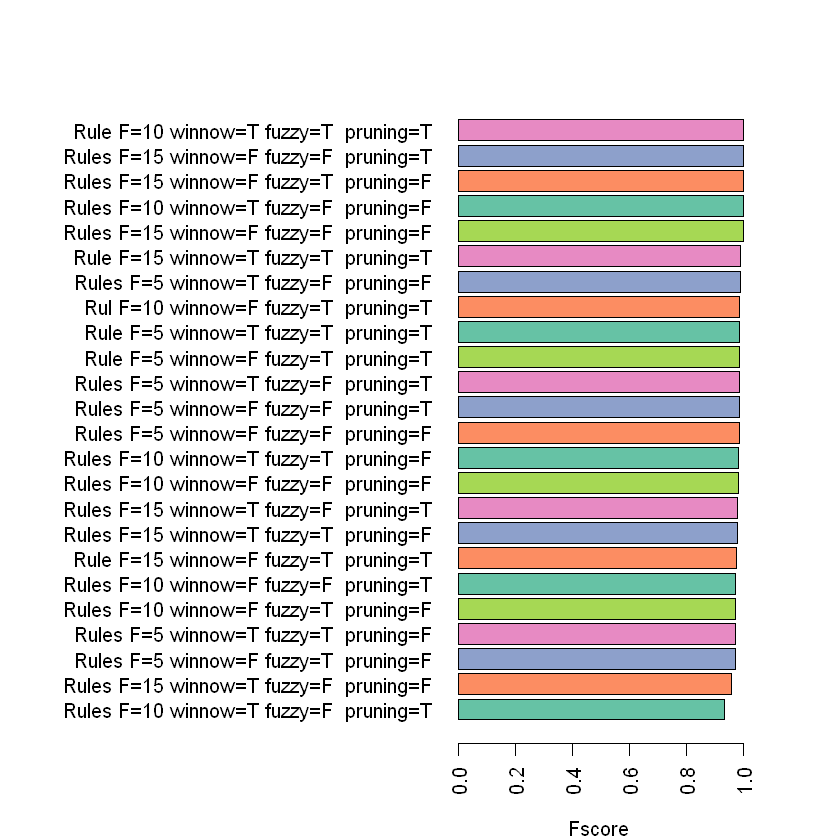

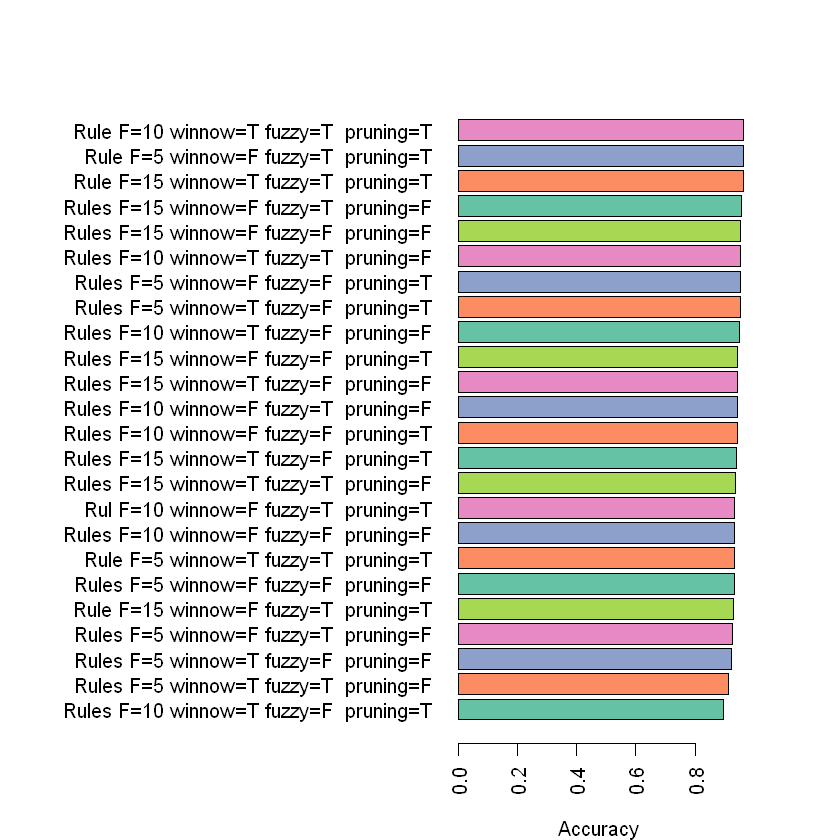

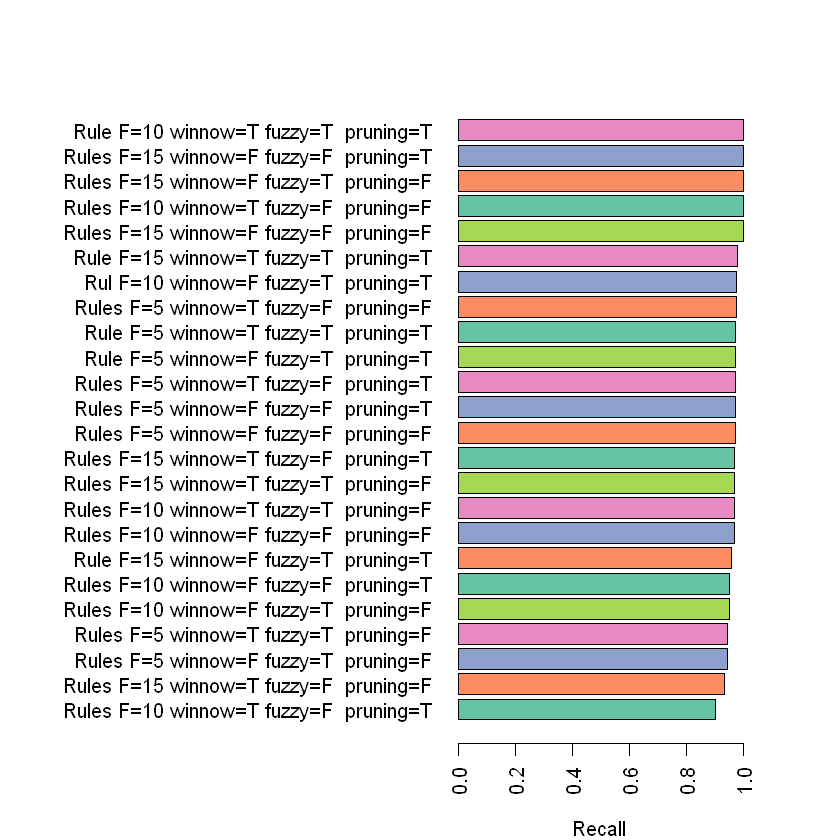

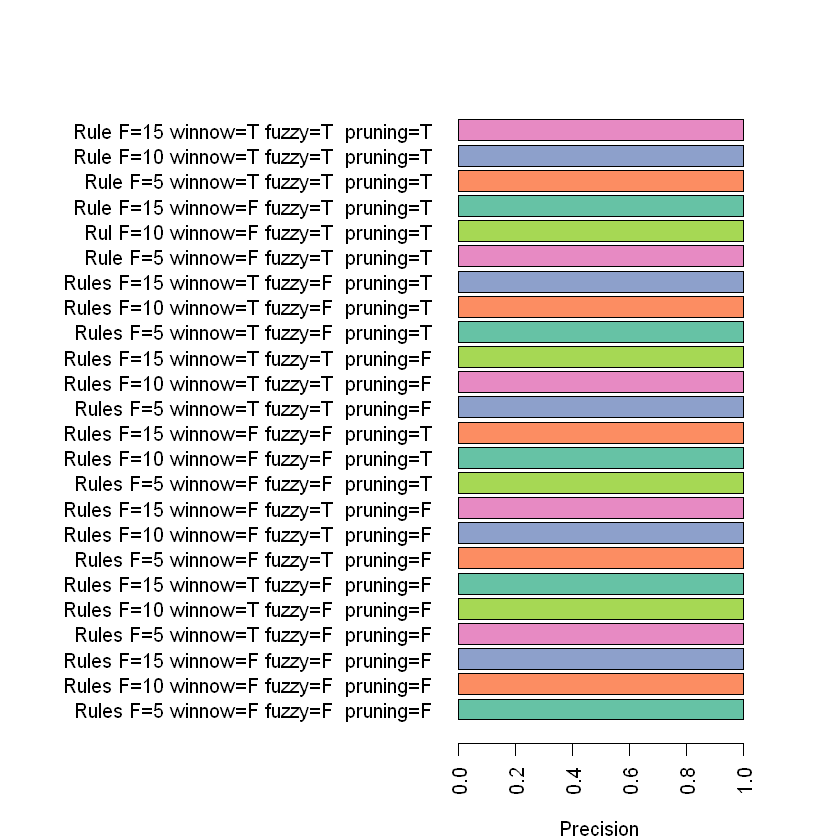

,params,f1,acc,rec,prec,Tree_size
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,Rules F=10 winnow=F fuzzy=F pruning=F,0.9800000,0.9342424,0.9666667,1,3
7,Rules F=5 winnow=F fuzzy=T pruning=F,0.9692308,0.9264069,0.9428571,1,3
8,Rules F=10 winnow=F fuzzy=T pruning=F,0.9714286,0.9443939,0.9500000,1,3
9,Rules F=15 winnow=F fuzzy=T pruning=F,1.0000000,0.9587302,1.0000000,1,3
10,Rules F=5 winnow=F fuzzy=F pruning=T,0.9846154,0.9536797,0.9714286,1,3
11,Rules F=10 winnow=F fuzzy=F pruning=T,0.9714286,0.9434848,0.9500000,1,3
14,Rules F=10 winnow=T fuzzy=T pruning=F,0.9800000,0.9547980,0.9666667,1,3
15,Rules F=15 winnow=T fuzzy=T pruning=F,0.9777778,0.9365079,0.9666667,1,3
17,Rules F=10 winnow=T fuzzy=F pruning=T,0.9333333,0.8977273,0.9000000,1,3


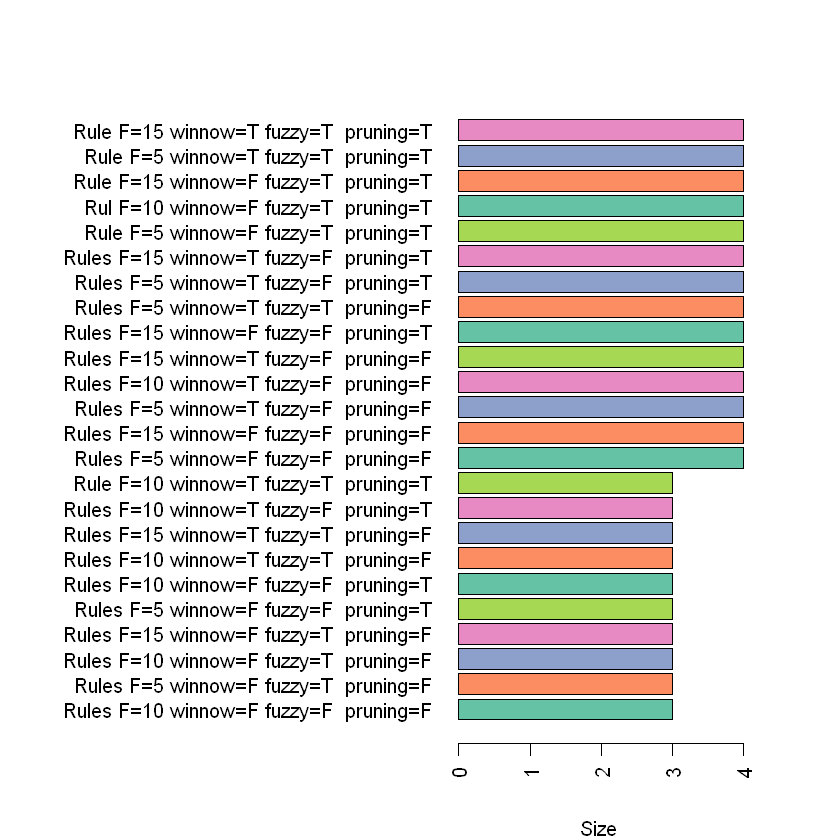

In [64]:
print('Iris')
research(iris_data,2,6,Species~.)

[1] "Seeds"


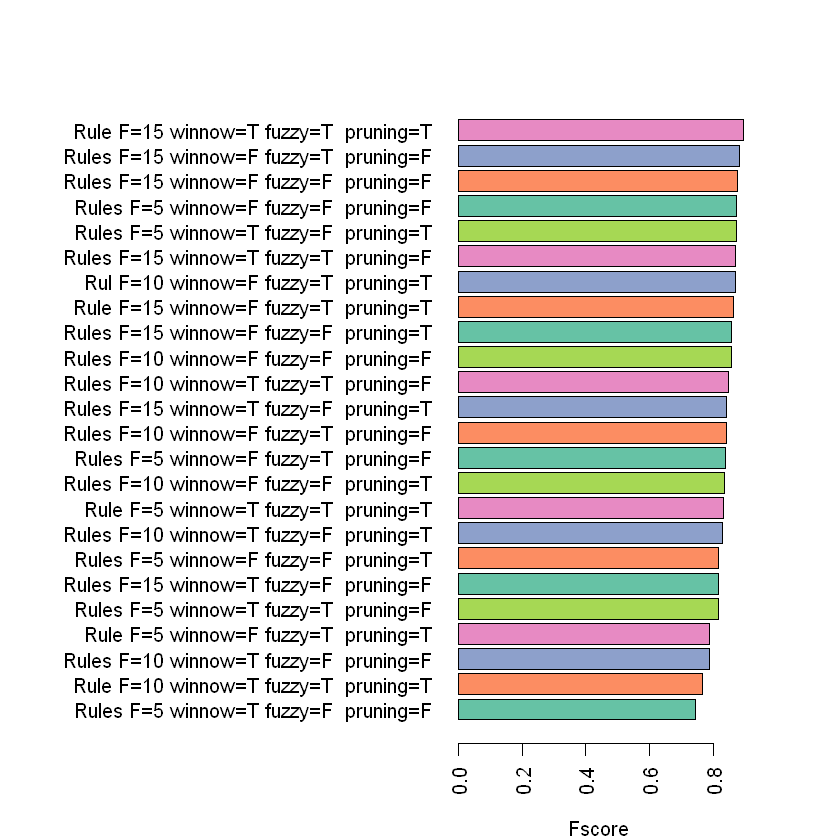

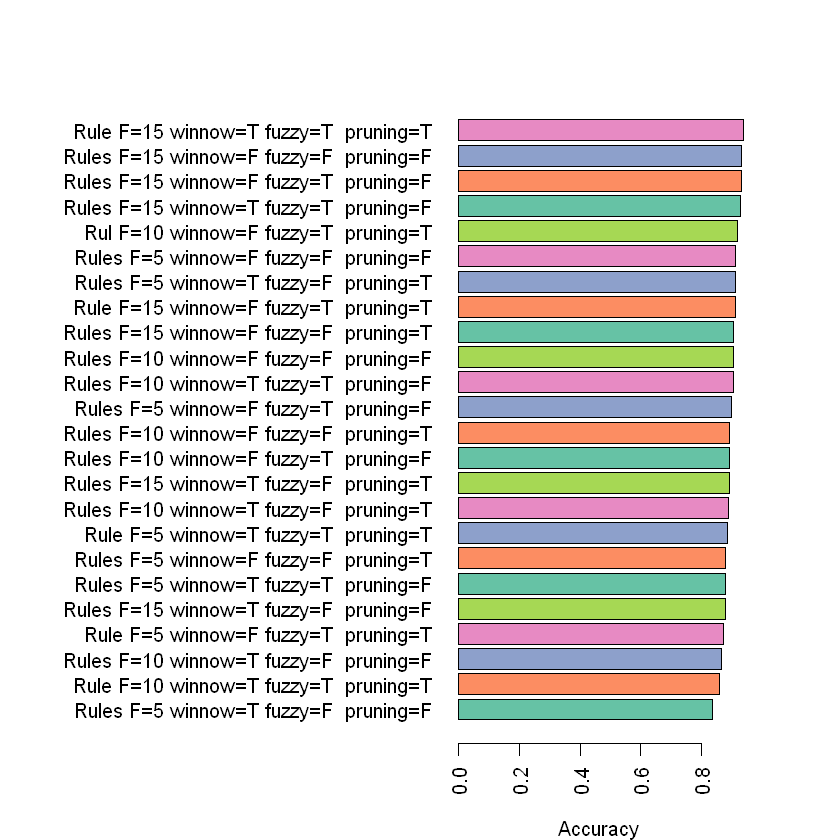

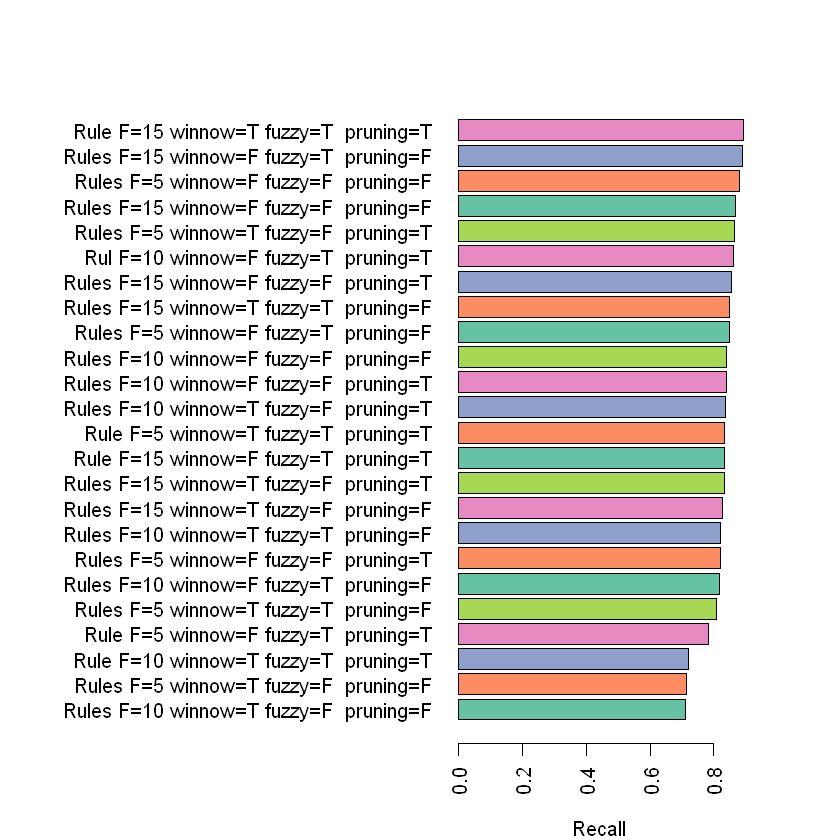

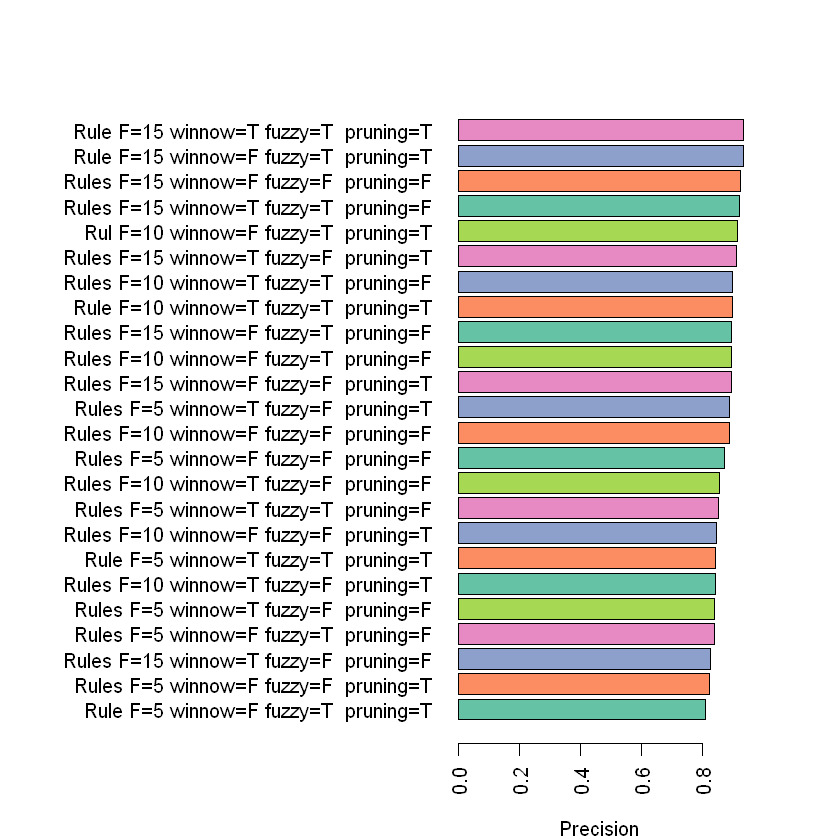

,params,f1,acc,rec,prec,Tree_size
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Rules F=5 winnow=F fuzzy=F pruning=F,0.8730463,0.9128736,0.8800000,0.8717172,4
4,Rules F=5 winnow=T fuzzy=F pruning=F,0.7442796,0.8383908,0.7127273,0.8385714,4
9,Rules F=15 winnow=F fuzzy=T pruning=F,0.8825397,0.9324579,0.8888889,0.8944444,4
16,Rules F=5 winnow=T fuzzy=F pruning=T,0.8728427,0.9126140,0.8636364,0.8872727,4
22,Rule F=5 winnow=T fuzzy=T pruning=T,0.8335622,0.8859770,0.8345455,0.8421212,4
23,Rule F=10 winnow=T fuzzy=T pruning=T,0.7672222,0.8596429,0.7200000,0.8954762,4
3,Rules F=15 winnow=F fuzzy=F pruning=F,0.8765079,0.9329293,0.8666667,0.9222222,5
14,Rules F=10 winnow=T fuzzy=T pruning=F,0.8477273,0.9061905,0.8200000,0.8966667,5
15,Rules F=15 winnow=T fuzzy=T pruning=F,0.8697354,0.9281145,0.8500000,0.9200000,5


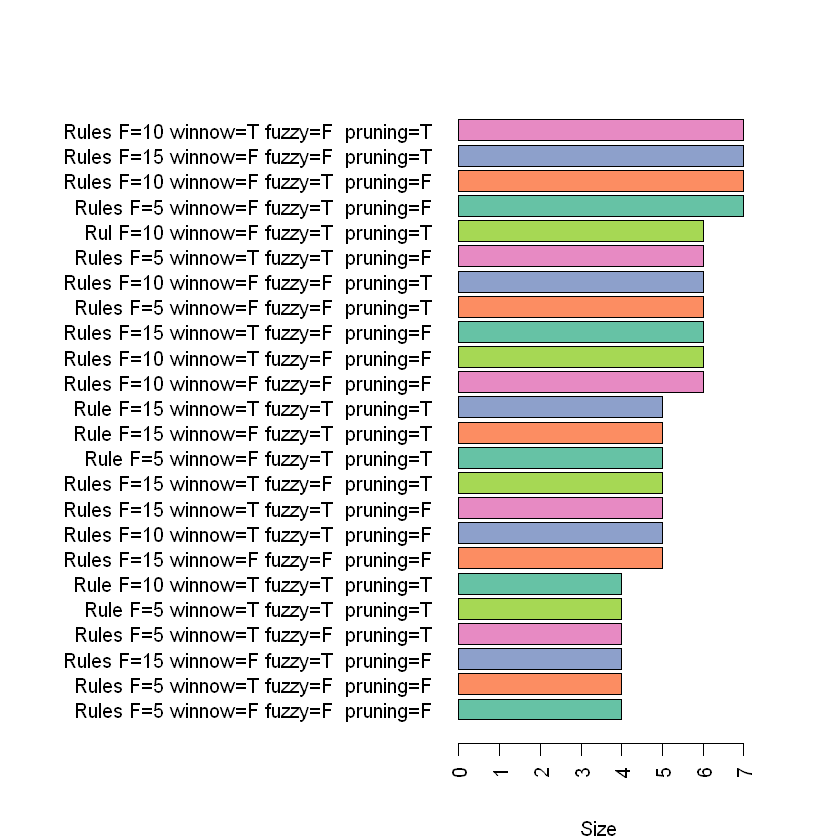

In [70]:
print('Seeds')
research(seed_data,1,8,Type~.)

[1] "Glass"


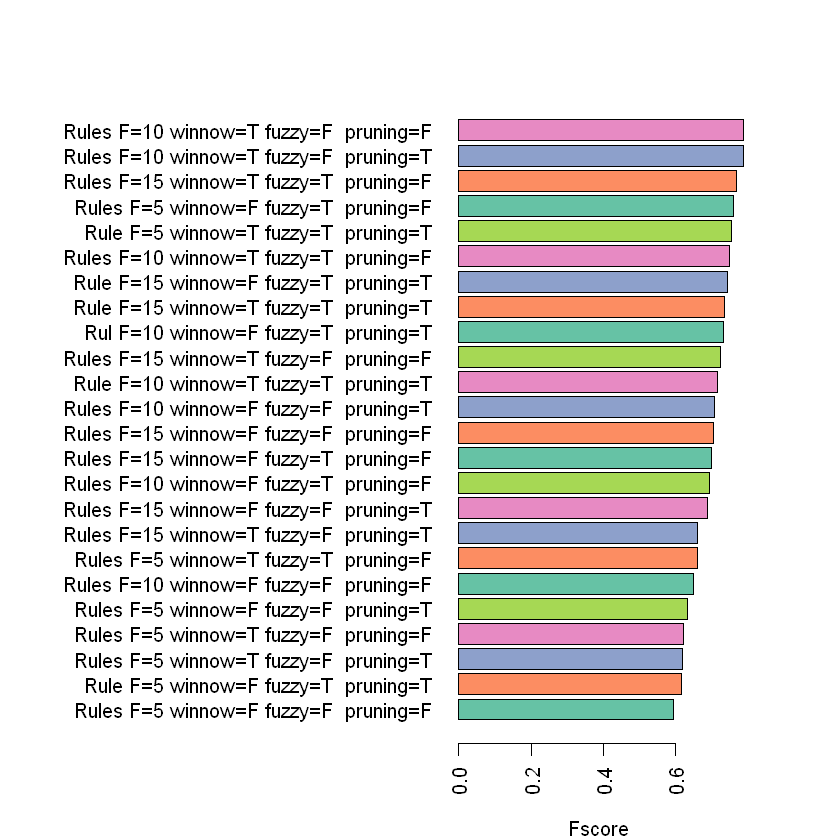

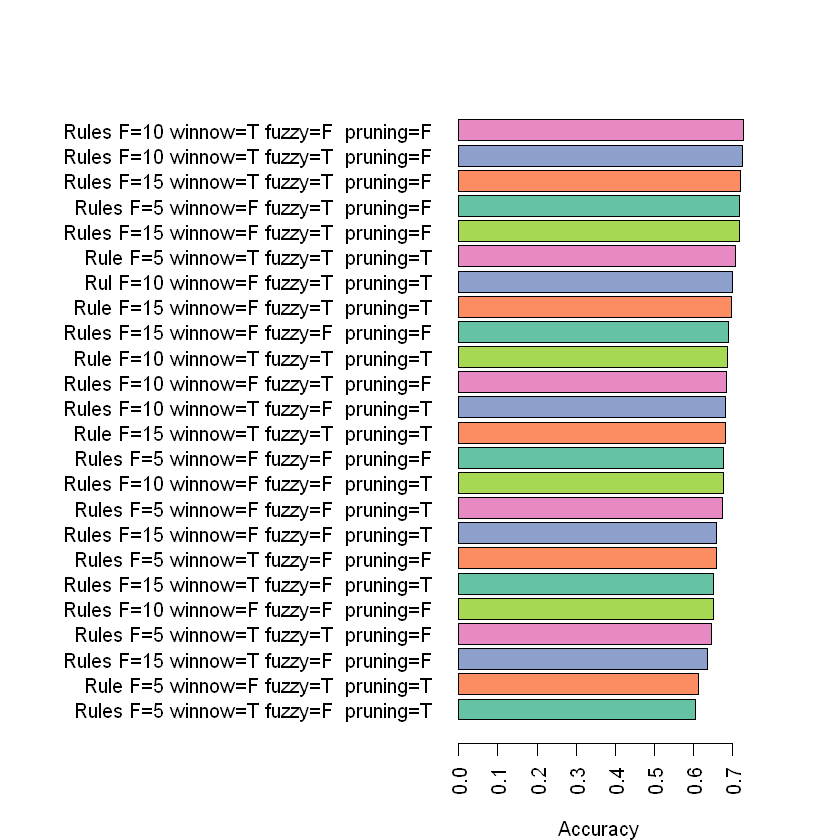

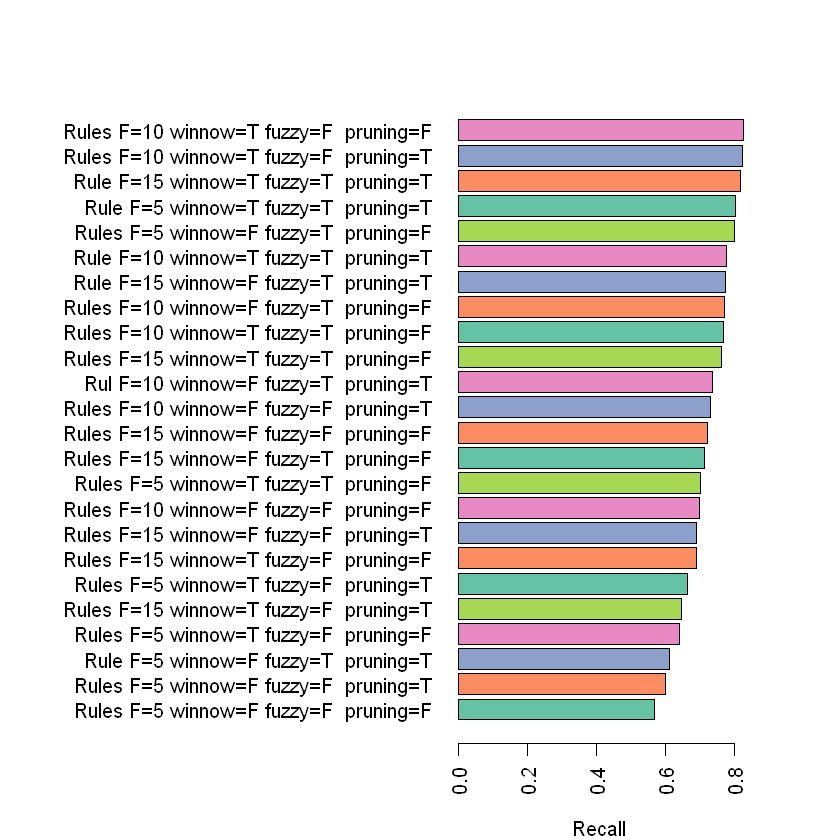

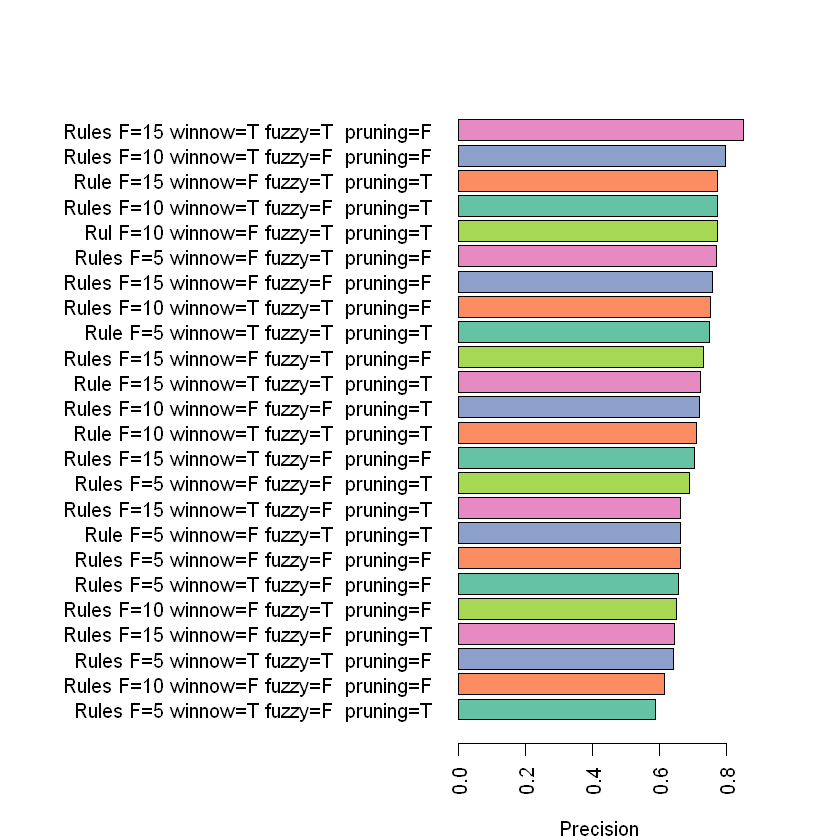

,params,f1,acc,rec,prec,Tree_size
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,Rules F=15 winnow=F fuzzy=F pruning=F,0.7046032,0.6899586,0.7222222,0.7566667,8
9,Rules F=15 winnow=F fuzzy=T pruning=F,0.6974603,0.7165411,0.7111111,0.7300000,8
14,Rules F=10 winnow=T fuzzy=T pruning=F,0.7498268,0.7261355,0.7666667,0.7516667,9
16,Rules F=5 winnow=T fuzzy=F pruning=T,0.6177886,0.6060734,0.6618182,0.5877234,9
7,Rules F=5 winnow=F fuzzy=T pruning=F,0.7583750,0.7172154,0.8000000,0.7700758,10
11,Rules F=10 winnow=F fuzzy=F pruning=T,0.7064502,0.6755392,0.7300000,0.7188095,10
17,Rules F=10 winnow=T fuzzy=F pruning=T,0.7873449,0.6808974,0.8233333,0.7711111,10
18,Rules F=15 winnow=T fuzzy=F pruning=T,0.6603741,0.6511111,0.6444444,0.6630159,10
19,Rule F=5 winnow=F fuzzy=T pruning=T,0.6149328,0.6123963,0.6109091,0.6624242,10


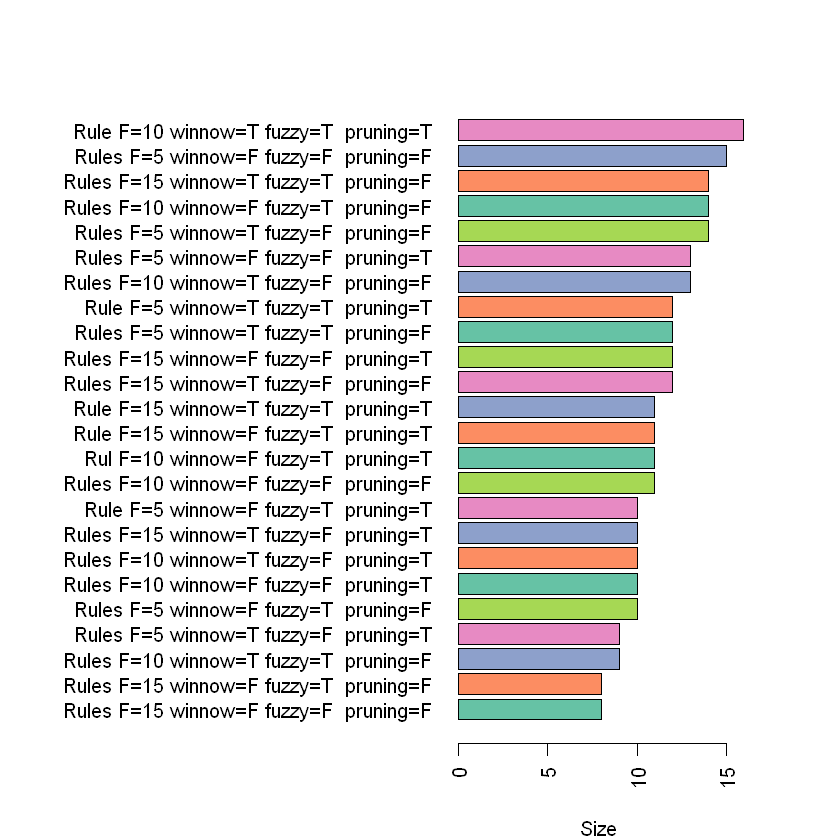

In [66]:
print('Glass')
research(glass_data,1,10,Type~. )

[1] "Wine quality"


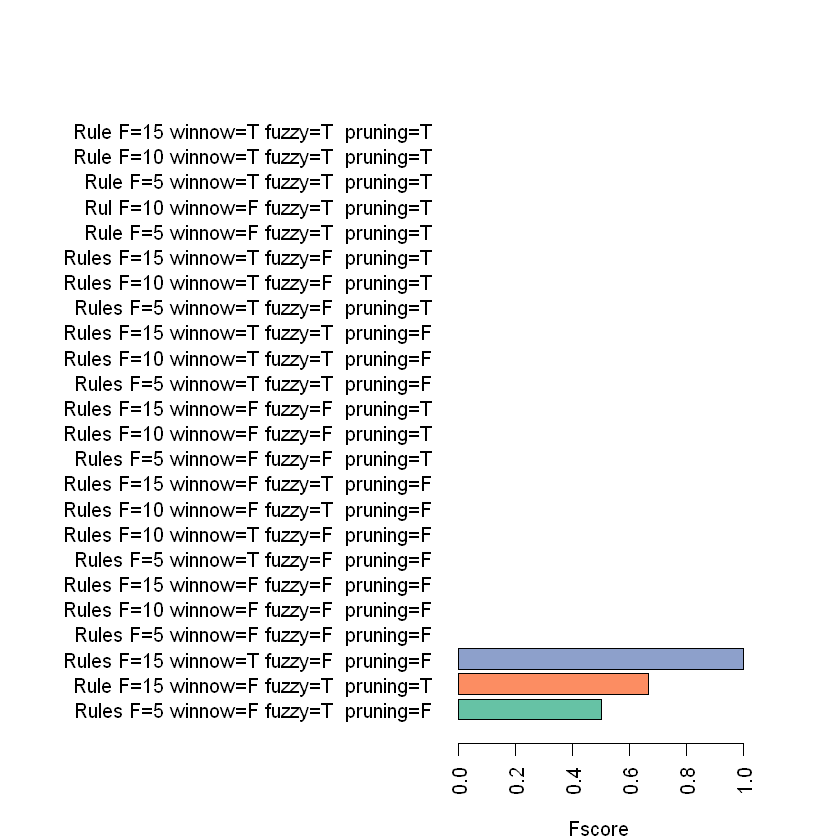

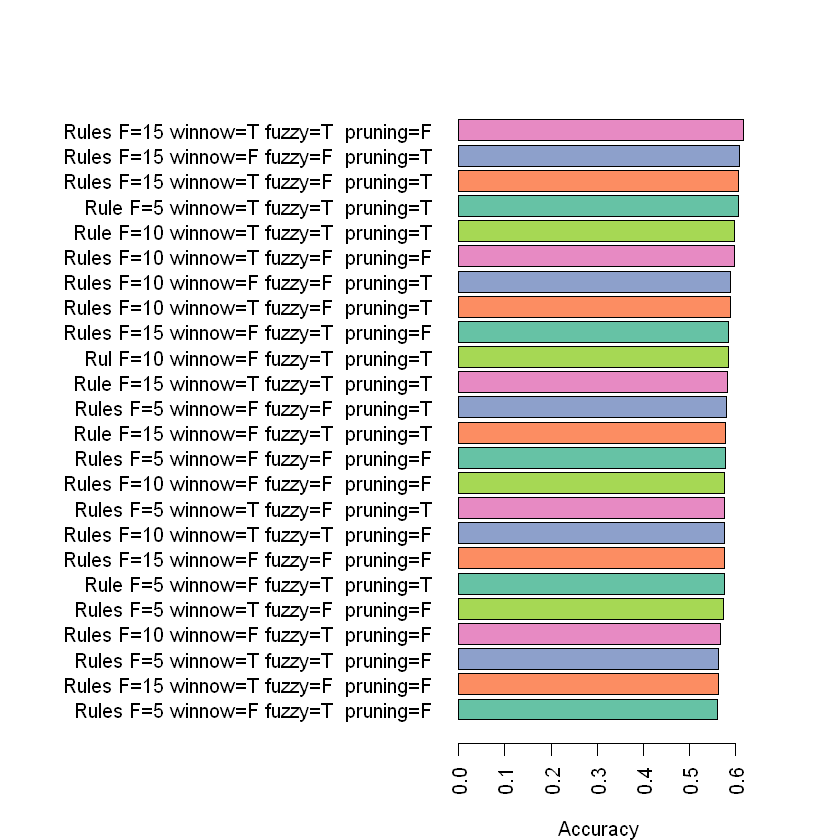

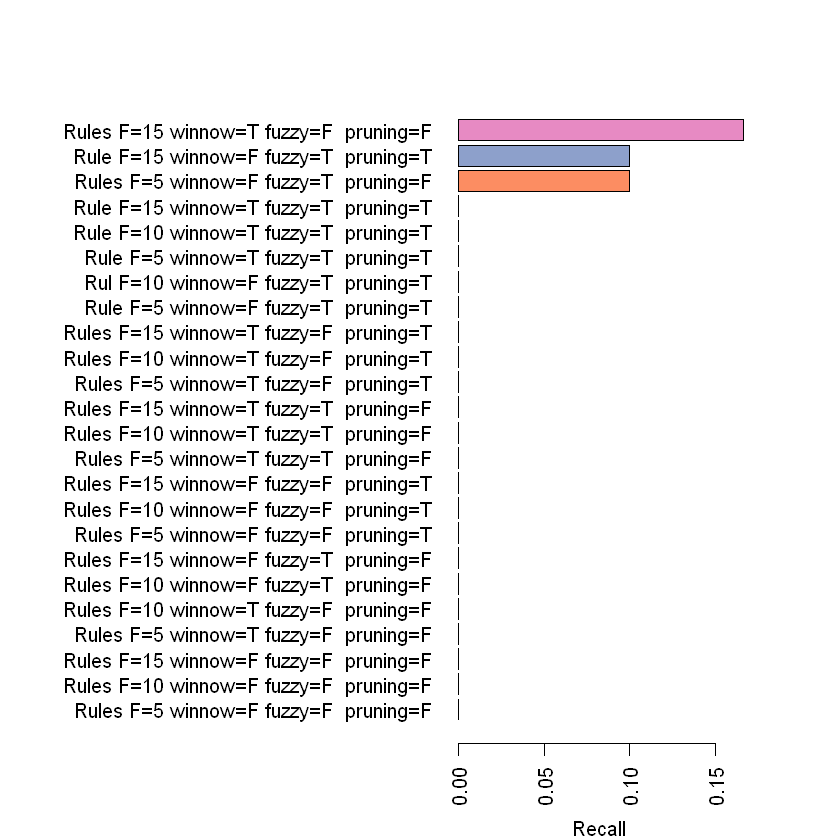

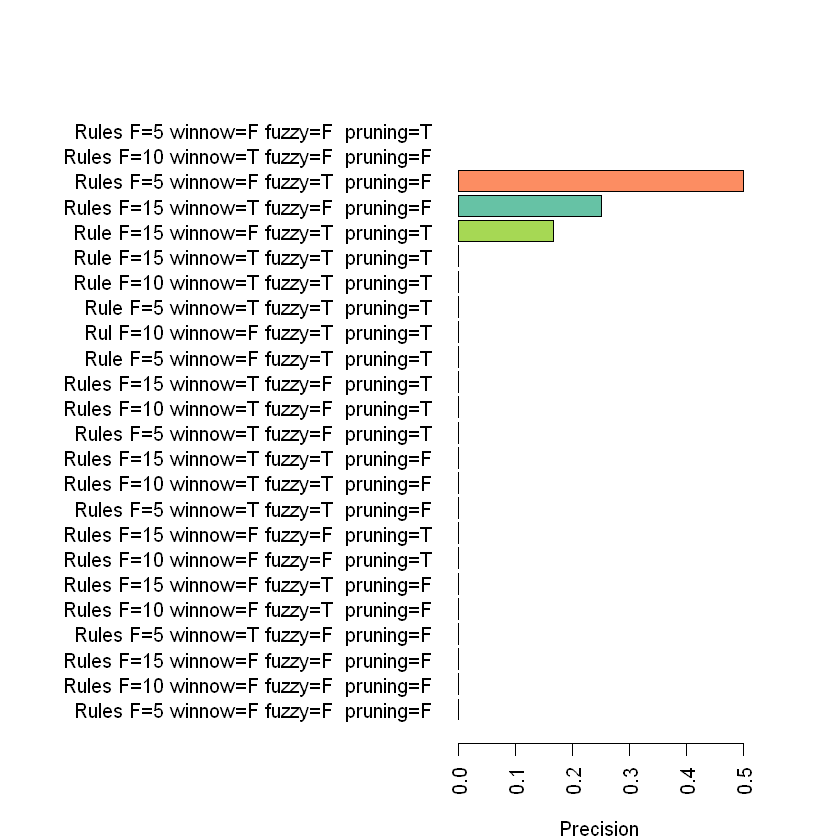

,params,f1,acc,rec,prec,Tree_size
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Rules F=5 winnow=F fuzzy=F pruning=F,NaN,0.5771076,0.0000000,0.0000000,55
6,Rules F=15 winnow=T fuzzy=F pruning=F,1.0000000,0.5621273,0.1666667,0.2500000,56
19,Rule F=5 winnow=F fuzzy=T pruning=T,NaN,0.5754337,0.0000000,0.0000000,56
17,Rules F=10 winnow=T fuzzy=F pruning=T,NaN,0.5880090,0.0000000,0.0000000,57
4,Rules F=5 winnow=T fuzzy=F pruning=F,NaN,0.5744729,0.0000000,0.0000000,59
12,Rules F=15 winnow=F fuzzy=F pruning=T,NaN,0.6082930,0.0000000,0.0000000,60
14,Rules F=10 winnow=T fuzzy=T pruning=F,NaN,0.5762579,0.0000000,0.0000000,61
22,Rule F=5 winnow=T fuzzy=T pruning=T,NaN,0.6065162,0.0000000,0.0000000,61
10,Rules F=5 winnow=F fuzzy=F pruning=T,NaN,0.5807467,0.0000000,NaN,62


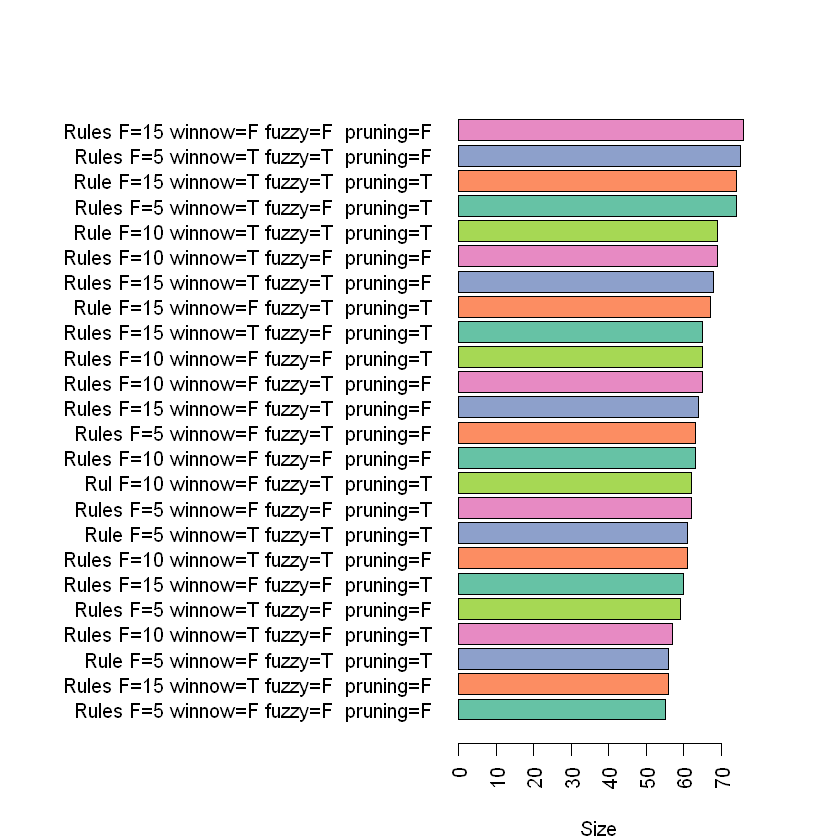

In [68]:
print('Wine quality')
research(wine_data,1,12,quality~.)



In [ ]:
library(C50)
in_train <- sample(3:nrow(iris_data), size = 100)
train_data <- iris_data[ in_train,]
test_data  <- iris_data[-in_train,]
tree_mod <- C5.0(x = train_data[, 2:6], y = train_data[,6])
plot(tree_mod)

5. Identyfikacja parametrów c4.5 (c5.0) – proszę wybrać 3 kluczowe do analizy
6. Analiza drzewa (można „narysować”!), analiza reguł i jakości klasyfikatora
7. Porównanie najlepszych wyników dla c4.5 (c5.0) i naiwnego Bayesa?

1. Jakie parametry ma C5.0 (C4.5) ? Jakie mają wartości są „optymalne”?
2. Jak rozmiar/typ krosswalidacji wpływa na jakość końcowego klasyfikatora? Dlaczego?
3. Czy C5.0 (C4.5) potrzebuje dyskretyzacji?
4. Czy drzewo może być „za małe” lub „za duże”? Co na to wpływa?
5. Jaką rolę pełni przycinanie drzewa i czy zawsze jest potrzebne?
6. Czy drzewo można „przeuczyć”?
7. Który z modeli klasyfikacji jest lepszy? I czy wszystkie zbiory tak samo się „zachowują”?


Bibliografia:
- https://www.mimuw.edu.pl/~awojna/SID/referaty/strzelczak/c4_5Main.html
- https://cran.r-project.org/web/packages/C50/C50.pdf
- https://rpubs.com/maulikpatel/229337
- https://www.r-bloggers.com/handling-class-imbalance-with-r-and-caret-caveats-when-using-the-auc/
- https://topepo.github.io/caret/available-models.html

In [ ]:
#Experiment - prototypes
research_dataframe<-data.frame()
newMeasureDataframe <- TreeModel_caret(iris_data,1,6,Species~. ,5,FALSE)
print(newMeasureDataframe)
research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
newMeasureDataframe = TreeModel_caret(glass_data,1,10,Type~. ,5,FALSE)
research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
newMeasureDataframe = TreeModel_caret(wine_data,1,12,quality~. ,5,FALSE)
research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
print(research_dataframe)